## 스프린트 미션 #6
#### 3팀 전수현 
#### 제출일자: 25.07.01

이번 과제는 캐글의 `chest-xray-pneumonia` 데이터를 이용하여 분류 문제를 Transfer learning을 통해서 진행해보는 과제이다. 코드잇에서 제공한 baseline 코드를 기준으로 개인적인 목표를 정해보았다.  

이번 과제의 목표는 

1) torchvision의 여러 pretrained model을 활용하여 transfer learning을 하고 성능을 비교한다.
2) 여러 평가 지표 Confusion Matrix, Precision, Recall, F1-Score, ROC-AUC를 활용하여 모델 평가
4) 학습률 스케줄러 (Learning Rate Scheduler) 활용하여 learning rate 관리
4) Early Stopping 적용
5) 다양한 Data augmentation 적용 


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: /home/soohyun/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


## 0. Import Libraries

In [2]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용한 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path


# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화 라이브러리
import seaborn as sns  # 고급 시각화 (히트맵, 스타일 등)

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# PyTorch 기본 구성
import torch  # 텐서, 연산 등
import torch.nn as nn  # 모델 정의 (layer, loss 등)
import torch.nn.functional as F
import torch.optim as optim  # Optimizer (SGD, Adam 등)

# PyTorch 데이터 처리
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋, 배치 로딩

# PyTorch 이미지 전처리
from torchvision import transforms  # 기본 이미지 transform
from torchvision import datasets  # torchvision 내장 데이터셋
import torchvision.models as models

from torchvision.transforms import v2  # torchvision v2 transforms (최신 API)

# 싸이킷런 평가 지표
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split


# 실험 추적 및 하이퍼파라미터 관리
import wandb  # Weights & Biases - 실험 로깅, 시각화, 하이퍼파라미터 튜닝

import gc  # Garbage Collector 모듈

## 1. Set configuration

In [3]:
# ====================================================================
# STEP 1: Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하는 습관을 들이자

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 주요 하이퍼파라미터
LEARNING_RATE = 1e-4  # 학습률 (optimizer용)
BATCH_SIZE = 128  # 배치 크기
NUM_EPOCHS = 1  # 학습 epoch 수
# SEED = 42  # 재현성을 위한 random seed

# 데이터 경로 설정
DATA_ROOT = "./data/chest_xray"
train_dir = os.path.join(DATA_ROOT, "train")
val_dir = os.path.join(DATA_ROOT, "val")
test_dir = os.path.join(DATA_ROOT, "test")

# 모델 설정
MODEL_NAME = "ResNet18"  # 또는 "EfficientNet", 등등
USE_PRETRAINED = True  # torchvision 모델 사용 여부

# 학습 고도화 설정 (Optional)
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# 실험 로깅용 설정
USE_WANDB = True
WANDB_PROJECT = "chest-xray-classification"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"

Using device: cuda


## 2. Data pre-processing

먼저, data loader에서 1개의 batch를 가져와서 plot해보기

Class names: ['NORMAL', 'PNEUMONIA']


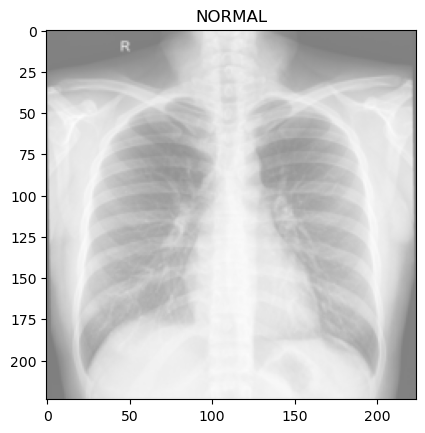

image: torch.Size([32, 3, 224, 224])
label: torch.Size([32])


In [4]:
# ====================================================================
# STEP 2: Data Preprocessing
# ====================================================================

transforms = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))


# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

print(f"image: {images.size()}")
print(f"label: {labels.size()}")

In [5]:
# 검증 데이터셋 디렉토리 경로 설정
val_dir = Path("./data/chest_xray/val")

# val_dir 및 모든 하위 디렉토리에서 .jpeg 확장자를 가진 파일 찾기
# '**/*.jpeg' 패턴은 모든 하위 폴더를 재귀적으로 탐색하라는 의미야.
image_files = list(val_dir.glob("**/*.jpeg"))

# 찾은 파일의 총 개수 계산
num_images = len(image_files)

print(f"'{val_dir}': {num_images}")

'data/chest_xray/val': 16


그런데 데이터를 자세히 보면 Validation set가 16개임을 알 수 있다. valdiation set의 중요성은 이번 과제의 목표인 early stopping 기법에도 활용이 되고 여러모로 학습에서 매우 중요하기 때문에 직접 재구성해주어야 한다.

In [6]:
# validation set을 재구성
original_train_dir = Path("./data/chest_xray/train")
class_names = ["NORMAL", "PNEUMONIA"]

all_image_paths = []
all_labels = []

# 각 클래스 폴더를 순회하며 파일 경로와 레이블 수집
for i, class_name in enumerate(class_names):
    class_dir = original_train_dir / class_name
    image_paths = list(class_dir.glob("*.jpeg"))
    all_image_paths.extend(image_paths)
    all_labels.extend([i] * len(image_paths))  # NORMAL은 0, PNEUMONIA는 1

print(f"trainset의 총 이미지 개수: {len(all_image_paths)}")
print(f"trainset의 총 레이블 개수: {len(all_labels)}")

trainset의 총 이미지 개수: 5216
trainset의 총 레이블 개수: 5216


In [7]:
from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련/검증 데이터 분할
# stratify=all_labels 옵션은 원본 데이터의 클래스 비율을 유지하면서 나눠줘. (매우 중요!)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.08,  # 검증 세트 비율
    random_state=42,  # 재현성을 위한 시드
    stratify=all_labels,  # 클래스 비율 유지
)

print(f"새로운 train set 데이터 개수: {len(train_paths)}")
print(f"새로운 validation set 데이터 개수: {len(val_paths)}")

새로운 train set 데이터 개수: 4798
새로운 validation set 데이터 개수: 418


In [8]:
# validation set 재구성을 위해서 새롭게 만든 Dataset 클래스
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 경로 리스트에서 idx에 해당하는 이미지 경로를 가져옴
        image_path = self.image_paths[idx]

        # PIL을 사용해 이미지 로드
        image = Image.open(image_path).convert("RGB")

        # 레이블 가져오기
        label = self.labels[idx]

        # 데이터 변환(augmentation 등) 적용
        if self.transform:
            image = self.transform(image)

        return image, label

이미지는 사이즈는 (3, 224, 224)이고 label은 2가지. 

이제 본격적인 이미지 전처리를 위해서 transform을 구성

In [9]:
# Data Augmentation
data_transforms = {
    "train": v2.Compose(
        [
            v2.Resize((224, 224)),  # 이미지 크기 조정
            v2.ColorJitter(brightness=0.2, contrast=0.2),
            v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToImage(),  #  PyTorch 텐서로 변환
            v2.ToDtype(torch.float32, scale=True),  # 텐서의 타입 float32, scaling
            v2.Normalize([0.5], [0.5]),  # 정규화
            v2.RandomErasing(p=0.5, scale=(0.02, 0.2)),  # 일부 영역 지우기
        ]
    ),
    "val": v2.Compose(
        [
            v2.Resize((224, 224)),  # 이미지 크기 조정
            v2.ToImage(),  #  PyTorch 텐서로 변환
            v2.ToDtype(torch.float32, scale=True),  # 텐서의 타입 float32, scaling
            v2.Normalize([0.5], [0.5]),  # 정규화
        ]
    ),
    "test": v2.Compose(
        [
            v2.Resize((224, 224)),  # 이미지 크기 조정
            v2.ToImage(),  #  PyTorch 텐서로 변환
            v2.ToDtype(torch.float32, scale=True),  # 텐서의 타입 float32, scaling
            v2.Normalize([0.5], [0.5]),  # 정규화
        ]
    ),
}

이제 데이터 전처리 과정이 완료된 이미지를 불러오기 위해서 dataloader에서 이미지 로드하고 시각화해보면

In [10]:
# 데이터셋 로드
train_dataset = CustomImageDataset(
    train_paths, train_labels, transform=data_transforms["train"]
)
val_dataset = CustomImageDataset(
    val_paths, val_labels, transform=data_transforms["val"]
)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 4798
Number of validation samples: 418
Number of test samples: 624


적절하게 dataset이 split 된것을 확인할 수 있었다.

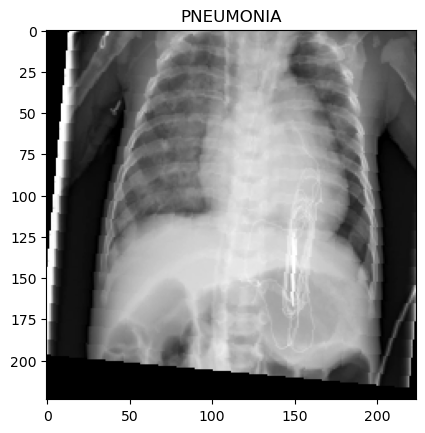

In [11]:
# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))


# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

## 3. 모델 구현하기

In [12]:
# ====================================================================
# STEP 3: Model implementation
# ====================================================================


# Custom CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, stride=1, padding=1
        )  # 입력 채널: 3, 출력 채널: 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv2D
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # Adaptive Pooling (7x7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully Connected Layer
        self.fc2 = nn.Linear(128, num_classes)  # Output Layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + Pooling
        x = self.avgpool(x)  # Adaptive Pooling
        x = torch.flatten(x, 1)  # Flattening
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.fc2(x)  # Output Layer
        return x


# 클래스 수 설정 (NORMAL, PNEUMONIA)
num_classes = len(class_names)

그런데 이 데이터의 문제는 데이터의 분포가 불균형이라는 것이다. 즉,

In [13]:
normal_train_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
pneumonia_train_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
weights = torch.tensor(
    [pneumonia_train_count / normal_train_count, 1.0],
    dtype=torch.float32,
    device=device,
)

print(f"Train - NORMAL: {normal_train_count}, PNEUMONIA: {pneumonia_train_count}")

Train - NORMAL: 1341, PNEUMONIA: 3875


위에 결과에서 볼 수 있듯이 'NORMAL'과 'PNEUMONIA'의 비율이 대략적으로 1:3으로 차이가 나기 때문에 학습 데이터가 편향되었다고 볼 수 있다. 이러한 편향을 보정하기 위해서 loss function에서 *가중 손실 함수를 적용*함

## 4. 모델 학습 및 평가

In [14]:
# ====================================================================
# STEP 4: train and evalutate
# ====================================================================


# 먼저, 학습에 쓰일 Ealystopping 클래스를 구현. pytorch나 다른 라이브러리에는 없다고 한다.
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self,
        patience=5,
        verbose=False,
        delta=0,
        path="/experiments/best_model.pth",
        trace_func=print,
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'best_model.pth'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [15]:
# ROC 커브 비교해주는 메서드
def ROCcomparison_result(results):
    plt.figure(figsize=(6, 6))

    for name, result in results.items():
        fpr, tpr, thresholds = roc_curve(result["labels"], result["probs"])
        # auc 함수로 AUC 점수 계산
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (area = {roc_auc:0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # 50% 성능의 기준선
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:
def train_fn(
    model: nn.Module,
    model_name: str,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion,
    optimizer,
    scheduler,
    num_epochs: int,
):
    print(f"** Start training a model {model_name} ** ")
    path_model = "experiments/" + model_name + ".pt"
    early_stopping = EarlyStopping(patience=5, verbose=True, path=path_model)
    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for inputs, labels in loop:
            # 데이터를 GPU/CPU로 이동
            inputs, labels = inputs.to(device), labels.to(device)

            # 이전 그래디언트 초기화
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            loss.backward()  # Backward Pass

            # 가중치 업데이트
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # 학습 손실 및 정확도 출력
        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # 검증 단계 수행
        eval_results = evaluate(model, val_loader, criterion)

        # Learning Rate Scheduler 적용. val_loss를 고려하여 learning rate를 조정
        if USE_SCHEDULER:
            scheduler.step(eval_results["loss"])

        # EarlyStopping 로직 호출
        early_stopping(eval_results["loss"], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        print(
            f"(Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f})(Val Loss: {eval_results['loss']:.4f} | Val Acc: {eval_results['accuracy']:.4f})"
        )

        print("***Valset evaluation***")
        print(
            f"Accuracy: {eval_results['accuracy']:.4f} | F1-Score: {eval_results['f1_score']:.4f}, Precision: {eval_results['precision']:.4f} |  Recall: {eval_results['recall']:.4f} "
        )
    print("Loading best model weights.")
    model.load_state_dict(torch.load(path_model))

In [17]:
def evaluate(model: nn.Module, dataloader: DataLoader, loss_fn) -> dict:
    model.eval()

    total_loss = 0.0  # 손실값을 저장할 리스트
    all_labels = []
    all_preds = []
    all_probs = []  # ROC 커브를 위한 확률값 리스트

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델의 예측값 계산
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            # 예측값 가져오기
            preds = torch.argmax(outputs, dim=1)

            # 소프트맥스를 적용해 확률 계산 (ROC 커브용)
            probs = F.softmax(outputs, dim=1)
            positive_probs = probs[:, 1]

            # 예측값과 실제 레이블을 CPU로 옮겨 리스트에 저장
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(positive_probs.cpu().numpy())

    # 평균 손실값과 정확도 계산
    avg_loss = total_loss / len(dataloader)

    # scikit-learn을 사용해 평가지표 계산
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, average="binary")
    recall = recall_score(all_labels, all_preds, average="binary")
    f1 = f1_score(all_labels, all_preds, average="binary")

    # 혼동 행렬도 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 결과를 딕셔너리 형태
    return {
        "loss": avg_loss,  # val loss
        "accuracy": accuracy,  # val accuracy
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
        "labels": np.array(all_labels),  # ROC 커브용 실제 레이블
        "probs": np.array(all_probs),  # ROC 커브용 예측 확률
    }

In [18]:
from sklearn.metrics import roc_curve, auc


# ROC 커브 단독
def plot_roc_curve(true_labels, predicted_probs):
    """
    ROC 커브를 그리고 AUC 점수를 표시하는 함수

    Args:
        true_labels (np.array): 실제 레이블 배열
        predicted_probs (np.array): 모델이 예측한 양성 클래스(PNEUMONIA)의 확률 배열
    """
    # roc_curve 함수로 FPR, TPR, 임계값 계산
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    # auc 함수로 AUC 점수 계산
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.3f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # 50% 성능의 기준선

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


# plot_roc_curve(test_results["labels"], test_results["probs"])


# ROC 커브 + Comfusion matrix
def Visualize_eval(test_results):
    # Confusion matrix 시각화
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1행 2열 subplot
    sns.heatmap(
        test_results["confusion_matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[0],
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # roc_curve 함수로 FPR, TPR, 임계값 계산
    fpr, tpr, thresholds = roc_curve(test_results["labels"], test_results["probs"])
    # auc 함수로 AUC 점수 계산
    roc_auc = auc(fpr, tpr)
    axes[1].plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.3f})"
    )
    axes[1].plot(
        [0, 1], [0, 1], color="navy", lw=2, linestyle="--"
    )  # 50% 성능의 기준선
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate (Recall)")
    axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
    axes[1].legend(loc="lower right")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## 5. Transfer Learning 실험. 총 3가지 모델 비교
- BaselineCNN, 
- BaselienResnet18 
- 그리고 resnet 기반 3가지 transfer learning의 기법들을 비교한다

In [19]:
result_1 = {}
# NUM_EPOCHS = 100
loss_fn = nn.CrossEntropyLoss(
    weight=weights
)  # 가중 손실함수 적용. 데이터가 더 적은 클래스에 높은 가중치를 줌

## 5-(1) Baseline CNN


In [20]:
model = CustomCNN(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

In [21]:
# 5-(1) Baseline CNN
MODEL_NAME = "baselineCNN"

train_fn(
    model,
    MODEL_NAME,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,  # NUM_EPOCHS
)

** Start training a model baselineCNN ** 


Epoch [1/1]: 100%|██████████| 38/38 [03:11<00:00,  5.05s/it]


Validation loss decreased (inf --> 0.626154).  Saving model ...
(Train Loss: 0.6737 | Train Acc: 0.5850)(Val Loss: 0.6262 | Val Acc: 0.6364)
***Valset evaluation***
Accuracy: 0.6364 | F1-Score: 0.6860, Precision: 0.9595 |  Recall: 0.5338 
Loading best model weights.


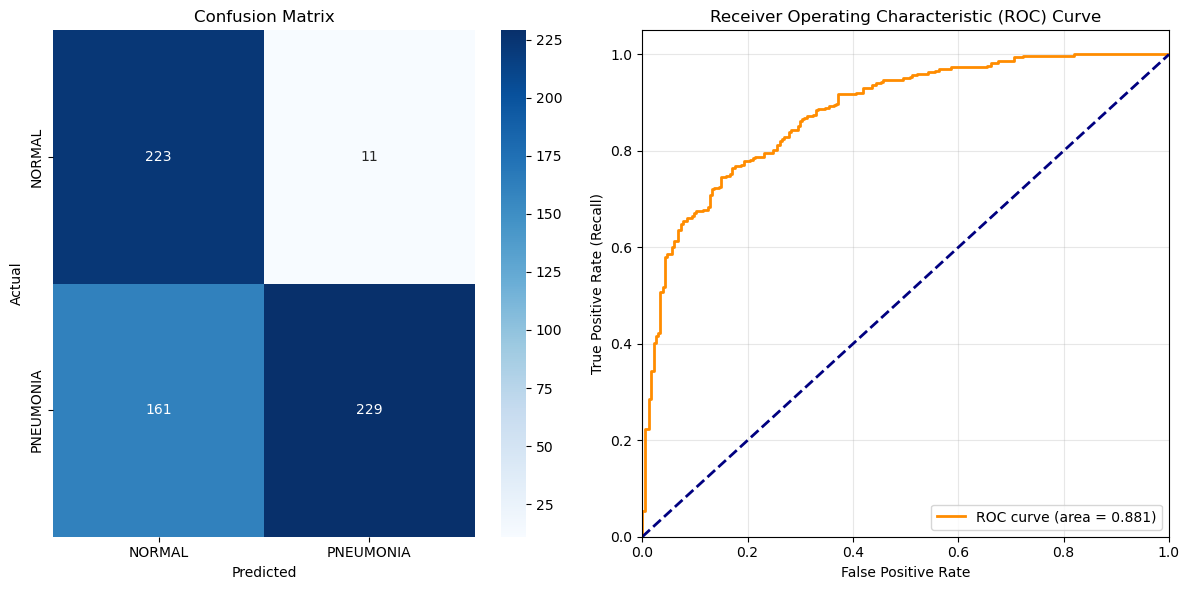

In [22]:
# 5-(1) Test set 결과
test_results = evaluate(model, test_loader, loss_fn)
Visualize_eval(test_results)
result_1[MODEL_NAME] = test_results

## 5-(2). 실험: Resnet 기반 


In [ ]:
# 메모리 정리 루틴
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [28]:
# 5-(2). 실험: Resnet 기반
MODEL_NAME = "resnet_baseline"
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
pretrained_model = models.resnet18(pretrained=False)  # pre-trained 아님 !


# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성

# 모든 층 학습 가능하도록 설정
for param in pretrained_model.parameters():
    param.requires_grad = True
pretrained_model = pretrained_model.to(device)

In [29]:
optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

train_fn(
    pretrained_model,
    MODEL_NAME,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,  # NUM_EPOCHS
)

** Start training a model resnet_baseline ** 


Epoch [1/100]: 100%|██████████| 38/38 [03:03<00:00,  4.84s/it]


Validation loss decreased (inf --> 0.535423).  Saving model ...
(Train Loss: 0.4848 | Train Acc: 0.7791)(Val Loss: 0.5354 | Val Acc: 0.8612)
***Valset evaluation***
Accuracy: 0.8612 | F1-Score: 0.9110, Precision: 0.8710 |  Recall: 0.9550 


Epoch [2/100]: 100%|██████████| 38/38 [03:07<00:00,  4.94s/it]


Validation loss decreased (0.535423 --> 0.345558).  Saving model ...
(Train Loss: 0.2802 | Train Acc: 0.8806)(Val Loss: 0.3456 | Val Acc: 0.9067)
***Valset evaluation***
Accuracy: 0.9067 | F1-Score: 0.9401, Precision: 0.9000 |  Recall: 0.9839 


Epoch [3/100]: 100%|██████████| 38/38 [03:23<00:00,  5.36s/it]


Validation loss decreased (0.345558 --> 0.180124).  Saving model ...
(Train Loss: 0.2317 | Train Acc: 0.9106)(Val Loss: 0.1801 | Val Acc: 0.9474)
***Valset evaluation***
Accuracy: 0.9474 | F1-Score: 0.9642, Precision: 0.9769 |  Recall: 0.9518 


Epoch [4/100]: 100%|██████████| 38/38 [03:14<00:00,  5.11s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.1880 | Train Acc: 0.9246)(Val Loss: 0.2915 | Val Acc: 0.9306)
***Valset evaluation***
Accuracy: 0.9306 | F1-Score: 0.9546, Precision: 0.9299 |  Recall: 0.9807 


Epoch [5/100]: 100%|██████████| 38/38 [03:06<00:00,  4.91s/it]


EarlyStopping counter: 2 out of 7
(Train Loss: 0.1765 | Train Acc: 0.9343)(Val Loss: 0.5356 | Val Acc: 0.8828)
***Valset evaluation***
Accuracy: 0.8828 | F1-Score: 0.9252, Precision: 0.8808 |  Recall: 0.9743 


Epoch [6/100]: 100%|██████████| 38/38 [03:14<00:00,  5.11s/it]


EarlyStopping counter: 3 out of 7
(Train Loss: 0.1682 | Train Acc: 0.9354)(Val Loss: 1.2476 | Val Acc: 0.6029)
***Valset evaluation***
Accuracy: 0.6029 | F1-Score: 0.6376, Precision: 0.9932 |  Recall: 0.4695 


Epoch [7/100]: 100%|██████████| 38/38 [03:07<00:00,  4.94s/it]


Validation loss decreased (0.180124 --> 0.153771).  Saving model ...
(Train Loss: 0.1246 | Train Acc: 0.9500)(Val Loss: 0.1538 | Val Acc: 0.9354)
***Valset evaluation***
Accuracy: 0.9354 | F1-Score: 0.9555, Precision: 0.9797 |  Recall: 0.9325 


Epoch [8/100]: 100%|██████████| 38/38 [03:11<00:00,  5.03s/it]


Validation loss decreased (0.153771 --> 0.153135).  Saving model ...
(Train Loss: 0.0982 | Train Acc: 0.9631)(Val Loss: 0.1531 | Val Acc: 0.9306)
***Valset evaluation***
Accuracy: 0.9306 | F1-Score: 0.9521, Precision: 0.9796 |  Recall: 0.9260 


Epoch [9/100]: 100%|██████████| 38/38 [03:05<00:00,  4.87s/it]


Validation loss decreased (0.153135 --> 0.131820).  Saving model ...
(Train Loss: 0.1026 | Train Acc: 0.9614)(Val Loss: 0.1318 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [10/100]: 100%|██████████| 38/38 [03:08<00:00,  4.96s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0988 | Train Acc: 0.9642)(Val Loss: 0.1686 | Val Acc: 0.9139)
***Valset evaluation***
Accuracy: 0.9139 | F1-Score: 0.9396, Precision: 0.9825 |  Recall: 0.9003 


Epoch [11/100]: 100%|██████████| 38/38 [03:07<00:00,  4.93s/it]


EarlyStopping counter: 2 out of 7
(Train Loss: 0.0986 | Train Acc: 0.9598)(Val Loss: 0.1458 | Val Acc: 0.9402)
***Valset evaluation***
Accuracy: 0.9402 | F1-Score: 0.9589, Precision: 0.9799 |  Recall: 0.9389 


Epoch [12/100]: 100%|██████████| 38/38 [03:06<00:00,  4.91s/it]


Validation loss decreased (0.131820 --> 0.131437).  Saving model ...
(Train Loss: 0.0977 | Train Acc: 0.9612)(Val Loss: 0.1314 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [13/100]: 100%|██████████| 38/38 [03:09<00:00,  4.98s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0937 | Train Acc: 0.9598)(Val Loss: 0.2390 | Val Acc: 0.8900)
***Valset evaluation***
Accuracy: 0.8900 | F1-Score: 0.9212, Precision: 0.9853 |  Recall: 0.8650 


Epoch [14/100]: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it]


EarlyStopping counter: 2 out of 7
(Train Loss: 0.0938 | Train Acc: 0.9656)(Val Loss: 0.1320 | Val Acc: 0.9641)
***Valset evaluation***
Accuracy: 0.9641 | F1-Score: 0.9761, Precision: 0.9684 |  Recall: 0.9839 


Epoch [15/100]: 100%|██████████| 38/38 [03:08<00:00,  4.95s/it]


EarlyStopping counter: 3 out of 7
(Train Loss: 0.0910 | Train Acc: 0.9658)(Val Loss: 0.1354 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [16/100]: 100%|██████████| 38/38 [03:07<00:00,  4.94s/it]


Validation loss decreased (0.131437 --> 0.120597).  Saving model ...
(Train Loss: 0.0846 | Train Acc: 0.9669)(Val Loss: 0.1206 | Val Acc: 0.9474)
***Valset evaluation***
Accuracy: 0.9474 | F1-Score: 0.9641, Precision: 0.9801 |  Recall: 0.9486 


Epoch [17/100]: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it]


Validation loss decreased (0.120597 --> 0.116989).  Saving model ...
(Train Loss: 0.0818 | Train Acc: 0.9708)(Val Loss: 0.1170 | Val Acc: 0.9474)
***Valset evaluation***
Accuracy: 0.9474 | F1-Score: 0.9641, Precision: 0.9801 |  Recall: 0.9486 


Epoch [18/100]: 100%|██████████| 38/38 [03:05<00:00,  4.88s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0827 | Train Acc: 0.9679)(Val Loss: 0.1218 | Val Acc: 0.9522)
***Valset evaluation***
Accuracy: 0.9522 | F1-Score: 0.9674, Precision: 0.9802 |  Recall: 0.9550 


Epoch [19/100]: 100%|██████████| 38/38 [03:03<00:00,  4.84s/it]


EarlyStopping counter: 2 out of 7
(Train Loss: 0.0778 | Train Acc: 0.9702)(Val Loss: 0.1187 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [20/100]: 100%|██████████| 38/38 [03:04<00:00,  4.87s/it]


EarlyStopping counter: 3 out of 7
(Train Loss: 0.0747 | Train Acc: 0.9712)(Val Loss: 0.1174 | Val Acc: 0.9450)
***Valset evaluation***
Accuracy: 0.9450 | F1-Score: 0.9624, Precision: 0.9800 |  Recall: 0.9453 


Epoch [21/100]: 100%|██████████| 38/38 [03:05<00:00,  4.88s/it]


EarlyStopping counter: 4 out of 7
(Train Loss: 0.0765 | Train Acc: 0.9712)(Val Loss: 0.1171 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [22/100]: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it]


EarlyStopping counter: 5 out of 7
(Train Loss: 0.0776 | Train Acc: 0.9708)(Val Loss: 0.1209 | Val Acc: 0.9402)
***Valset evaluation***
Accuracy: 0.9402 | F1-Score: 0.9589, Precision: 0.9799 |  Recall: 0.9389 


Epoch [23/100]: 100%|██████████| 38/38 [03:05<00:00,  4.87s/it]


EarlyStopping counter: 6 out of 7
(Train Loss: 0.0805 | Train Acc: 0.9687)(Val Loss: 0.1191 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [24/100]: 100%|██████████| 38/38 [03:06<00:00,  4.92s/it]


Validation loss decreased (0.116989 --> 0.116501).  Saving model ...
(Train Loss: 0.0744 | Train Acc: 0.9717)(Val Loss: 0.1165 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [25/100]: 100%|██████████| 38/38 [03:03<00:00,  4.82s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0794 | Train Acc: 0.9700)(Val Loss: 0.1180 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [26/100]: 100%|██████████| 38/38 [03:03<00:00,  4.83s/it]


Validation loss decreased (0.116501 --> 0.116064).  Saving model ...
(Train Loss: 0.0776 | Train Acc: 0.9704)(Val Loss: 0.1161 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [27/100]: 100%|██████████| 38/38 [03:02<00:00,  4.80s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0770 | Train Acc: 0.9708)(Val Loss: 0.1179 | Val Acc: 0.9450)
***Valset evaluation***
Accuracy: 0.9450 | F1-Score: 0.9624, Precision: 0.9800 |  Recall: 0.9453 


Epoch [28/100]: 100%|██████████| 38/38 [03:04<00:00,  4.85s/it]


EarlyStopping counter: 2 out of 7
(Train Loss: 0.0804 | Train Acc: 0.9677)(Val Loss: 0.1175 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [29/100]: 100%|██████████| 38/38 [03:01<00:00,  4.79s/it]


EarlyStopping counter: 3 out of 7
(Train Loss: 0.0763 | Train Acc: 0.9721)(Val Loss: 0.1168 | Val Acc: 0.9474)
***Valset evaluation***
Accuracy: 0.9474 | F1-Score: 0.9641, Precision: 0.9801 |  Recall: 0.9486 


Epoch [30/100]: 100%|██████████| 38/38 [03:04<00:00,  4.85s/it]


EarlyStopping counter: 4 out of 7
(Train Loss: 0.0788 | Train Acc: 0.9692)(Val Loss: 0.1199 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [31/100]: 100%|██████████| 38/38 [03:05<00:00,  4.88s/it]


Validation loss decreased (0.116064 --> 0.114819).  Saving model ...
(Train Loss: 0.0739 | Train Acc: 0.9717)(Val Loss: 0.1148 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [32/100]: 100%|██████████| 38/38 [03:03<00:00,  4.82s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0777 | Train Acc: 0.9696)(Val Loss: 0.1172 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [33/100]: 100%|██████████| 38/38 [03:03<00:00,  4.83s/it]


Validation loss decreased (0.114819 --> 0.114380).  Saving model ...
(Train Loss: 0.0821 | Train Acc: 0.9683)(Val Loss: 0.1144 | Val Acc: 0.9545)
***Valset evaluation***
Accuracy: 0.9545 | F1-Score: 0.9691, Precision: 0.9803 |  Recall: 0.9582 


Epoch [34/100]: 100%|██████████| 38/38 [03:04<00:00,  4.86s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0789 | Train Acc: 0.9694)(Val Loss: 0.1184 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [35/100]: 100%|██████████| 38/38 [03:01<00:00,  4.77s/it]


EarlyStopping counter: 2 out of 7
(Train Loss: 0.0765 | Train Acc: 0.9717)(Val Loss: 0.1161 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [36/100]: 100%|██████████| 38/38 [03:05<00:00,  4.87s/it]


EarlyStopping counter: 3 out of 7
(Train Loss: 0.0738 | Train Acc: 0.9723)(Val Loss: 0.1162 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [37/100]: 100%|██████████| 38/38 [03:07<00:00,  4.94s/it]


EarlyStopping counter: 4 out of 7
(Train Loss: 0.0880 | Train Acc: 0.9669)(Val Loss: 0.1157 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [38/100]: 100%|██████████| 38/38 [03:04<00:00,  4.86s/it]


Validation loss decreased (0.114380 --> 0.114340).  Saving model ...
(Train Loss: 0.0732 | Train Acc: 0.9721)(Val Loss: 0.1143 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [39/100]: 100%|██████████| 38/38 [03:03<00:00,  4.82s/it]


EarlyStopping counter: 1 out of 7
(Train Loss: 0.0764 | Train Acc: 0.9706)(Val Loss: 0.1166 | Val Acc: 0.9498)
***Valset evaluation***
Accuracy: 0.9498 | F1-Score: 0.9657, Precision: 0.9801 |  Recall: 0.9518 


Epoch [40/100]: 100%|██████████| 38/38 [03:04<00:00,  4.85s/it]


EarlyStopping counter: 2 out of 7
(Train Loss: 0.0866 | Train Acc: 0.9689)(Val Loss: 0.1186 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [41/100]: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it]


EarlyStopping counter: 3 out of 7
(Train Loss: 0.0771 | Train Acc: 0.9698)(Val Loss: 0.1191 | Val Acc: 0.9450)
***Valset evaluation***
Accuracy: 0.9450 | F1-Score: 0.9624, Precision: 0.9800 |  Recall: 0.9453 


Epoch [42/100]: 100%|██████████| 38/38 [03:04<00:00,  4.86s/it]


EarlyStopping counter: 4 out of 7
(Train Loss: 0.0872 | Train Acc: 0.9683)(Val Loss: 0.1214 | Val Acc: 0.9402)
***Valset evaluation***
Accuracy: 0.9402 | F1-Score: 0.9589, Precision: 0.9799 |  Recall: 0.9389 


Epoch [43/100]: 100%|██████████| 38/38 [03:03<00:00,  4.83s/it]


EarlyStopping counter: 5 out of 7
(Train Loss: 0.0824 | Train Acc: 0.9689)(Val Loss: 0.1207 | Val Acc: 0.9402)
***Valset evaluation***
Accuracy: 0.9402 | F1-Score: 0.9589, Precision: 0.9799 |  Recall: 0.9389 


Epoch [44/100]: 100%|██████████| 38/38 [03:05<00:00,  4.88s/it]


EarlyStopping counter: 6 out of 7
(Train Loss: 0.0806 | Train Acc: 0.9698)(Val Loss: 0.1186 | Val Acc: 0.9426)
***Valset evaluation***
Accuracy: 0.9426 | F1-Score: 0.9607, Precision: 0.9799 |  Recall: 0.9421 


Epoch [45/100]: 100%|██████████| 38/38 [03:04<00:00,  4.85s/it]


EarlyStopping counter: 7 out of 7
Early stopping
Loading best model weights.


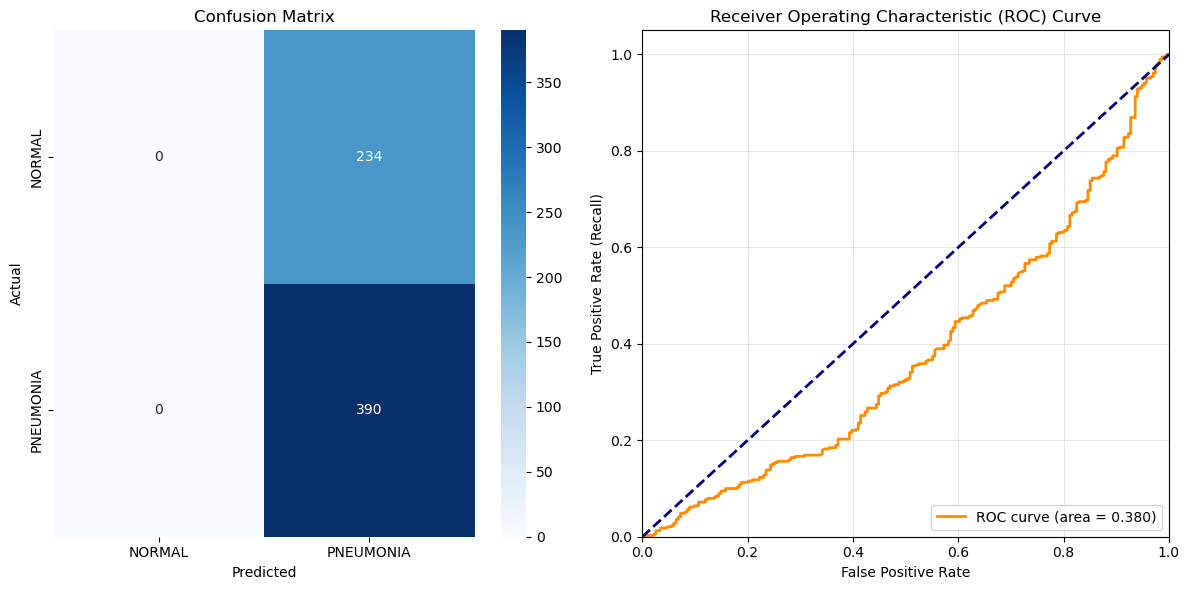

In [26]:
# 5-(2) Test set 결과
test_results = evaluate(pretrained_model, test_loader, loss_fn)
Visualize_eval(test_results)
result_1[MODEL_NAME] = test_results

이제 여러가지 모델과 훈련기법을 통해서 모델을 학습시키고 ROC 커브를 비교하면서 이 프로젝트를 마무리 짓겠다

## 5-(3) Transfer Learning: Feature extraction 훈련


In [27]:
# 메모리 정리 루틴
del pretrained_model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [28]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# Feature Extractor 동결 (파라미터 업데이트 불가)
for param in pretrained_model.parameters():
    param.requires_grad = False

# Classifier 교체 (기존 Fully Connected Layer를 새로운 Classifier로 교체)
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
print(pretrained_model.fc.weight.device)

cuda:0


** Start training a model resnet_Feat ** 


Epoch [1/1]: 100%|██████████| 38/38 [02:49<00:00,  4.47s/it]


Validation loss decreased (inf --> 0.795441).  Saving model ...
(Train Loss: 0.7592 | Train Acc: 0.4796)(Val Loss: 0.7954 | Val Acc: 0.3278)
***Valset evaluation***
Accuracy: 0.3278 | F1-Score: 0.3769, Precision: 0.6071 |  Recall: 0.2733 
Loading best model weights.


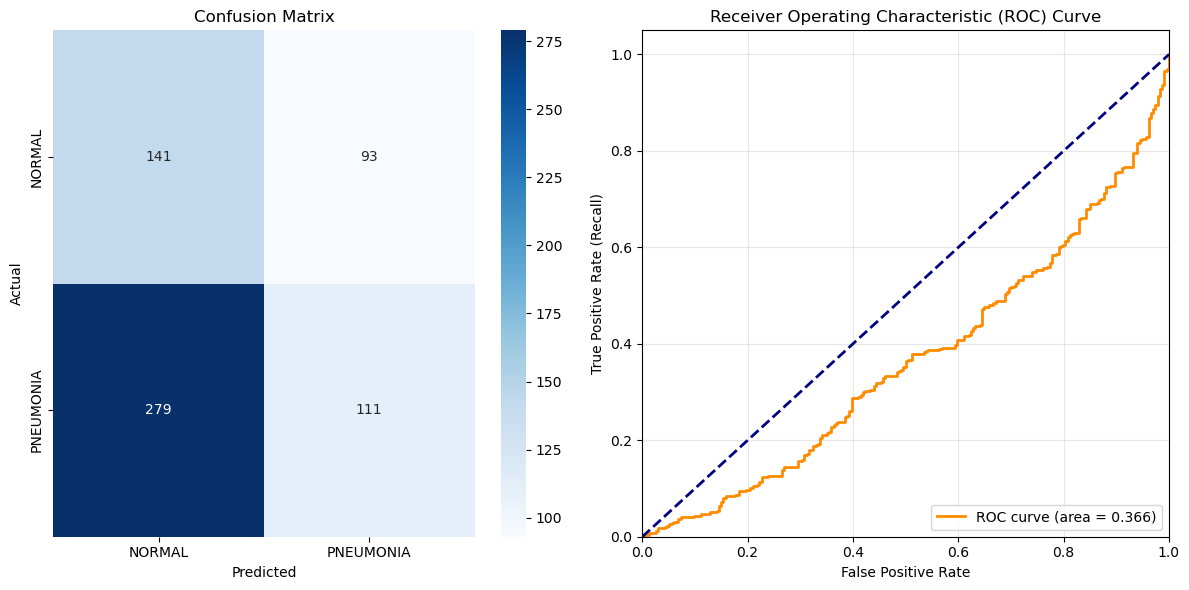

In [30]:
MODEL_NAME = "resnet_Feat"
# NUM_EPOCHS = 50

# Optimizer 설정
optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

# 학습 실행
train_fn(
    pretrained_model,
    MODEL_NAME,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
)
# 테스트 실행
test_results = evaluate(pretrained_model, test_loader, loss_fn)
Visualize_eval(test_results)
result_1[MODEL_NAME] = test_results

## 5-(4) Transfer Learning: Partial fine tuning 

In [31]:
# 메모리 정리 루틴
del pretrained_model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [32]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# Feature Extractor의 초기 층 동결
for name, param in pretrained_model.named_parameters():
    if (
        "layer4" in name or "fc" in name
    ):  # ResNet의 마지막 블록(layer4)와 Fully Connected Layer만 학습 가능
        param.requires_grad = True
    else:
        param.requires_grad = False

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성

print("Trainable parameters:")
for name, param in pretrained_model.named_parameters():
    if param.requires_grad:
        print(name)

pretrained_model = pretrained_model.to(device)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


** Start training a model resnet_Partial ** 


Epoch [1/1]: 100%|██████████| 38/38 [02:54<00:00,  4.59s/it]


Validation loss decreased (inf --> 0.235204).  Saving model ...
(Train Loss: 0.2261 | Train Acc: 0.9039)(Val Loss: 0.2352 | Val Acc: 0.9402)
***Valset evaluation***
Accuracy: 0.9402 | F1-Score: 0.9609, Precision: 0.9360 |  Recall: 0.9871 
Loading best model weights.


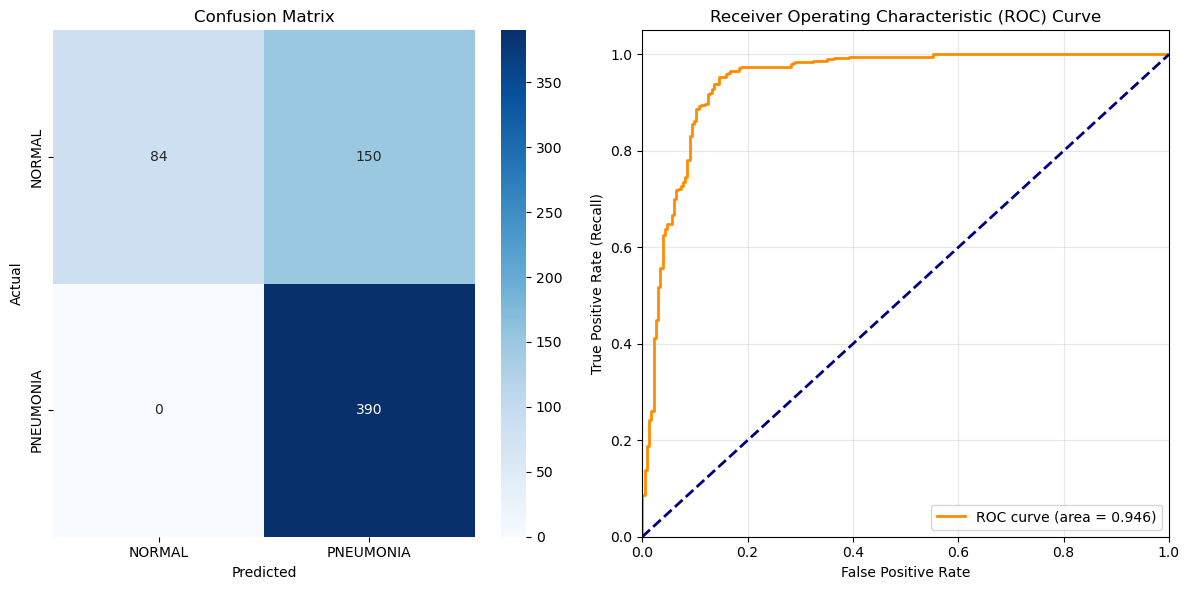

In [33]:
MODEL_NAME = "resnet_Partial"
# NUM_EPOCHS = 50


# Optimizer 설정
optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

# 학습 실행
train_fn(
    pretrained_model,
    MODEL_NAME,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
)

# 테스트 실행
test_results = evaluate(pretrained_model, test_loader, loss_fn)
Visualize_eval(test_results)
result_1[MODEL_NAME] = test_results

## 5-(5) Transfer Learning: Full fine tuning 

In [34]:
# 메모리 정리 루틴
del pretrained_model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [35]:
# Pretrained ResNet 모델 로드
pretrained_model = models.resnet18(pretrained=True)

# 모든 층 학습 가능하도록 설정
for param in pretrained_model.parameters():
    param.requires_grad = True

# Classifier 교체
num_features = pretrained_model.fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model.fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


** Start training a model resnet_Full ** 


Epoch [1/1]: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it]


Validation loss decreased (inf --> 0.098414).  Saving model ...
(Train Loss: 0.2283 | Train Acc: 0.8741)(Val Loss: 0.0984 | Val Acc: 0.9617)
***Valset evaluation***
Accuracy: 0.9617 | F1-Score: 0.9739, Precision: 0.9868 |  Recall: 0.9614 
Loading best model weights.


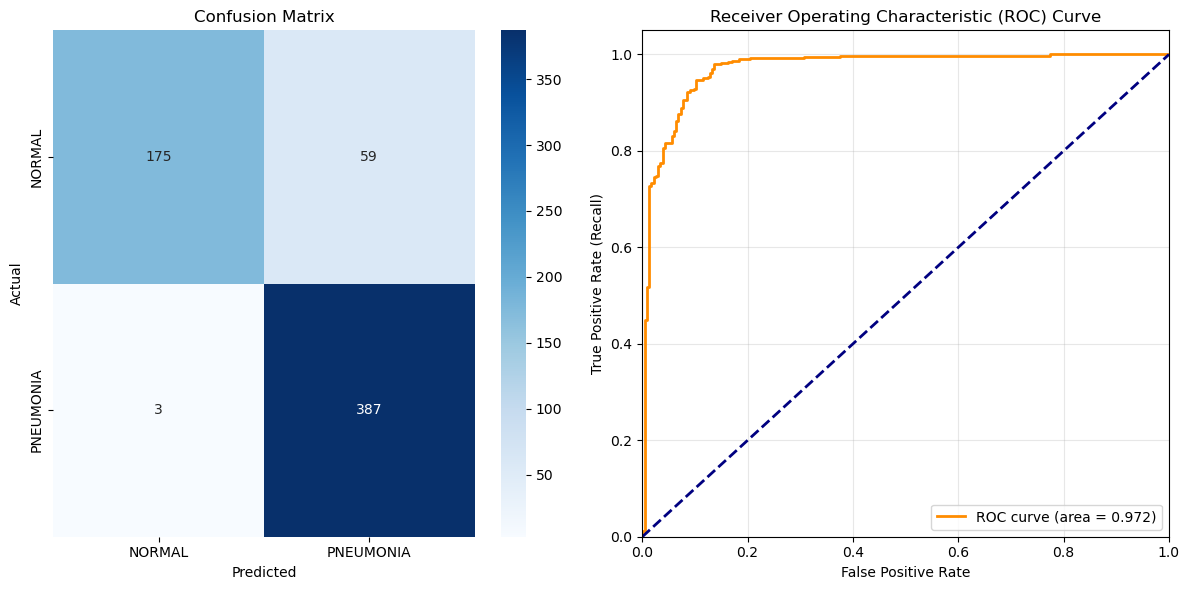

In [36]:
MODEL_NAME = "resnet_Full"
# NUM_EPOCHS = 50
# Optimizer 설정
optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)

# 학습 실행
train_fn(
    pretrained_model,
    MODEL_NAME,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
)

# 테스트 실행
test_results = evaluate(pretrained_model, test_loader, loss_fn)
Visualize_eval(test_results)
result_1[MODEL_NAME] = test_results

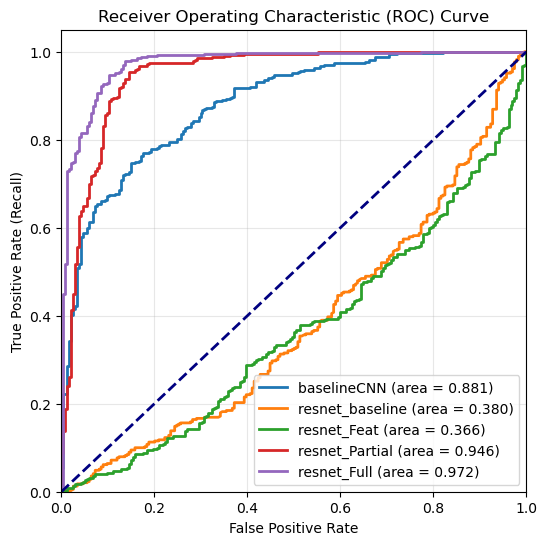

In [37]:
#     def plot_roc_curve(true_labels, predicted_probs):
# """
# ROC 커브를 그리고 AUC 점수를 표시하는 함수

# Args:
#     true_labels (np.array): 실제 레이블 배열
#     predicted_probs (np.array): 모델이 예측한 양성 클래스(PNEUMONIA)의 확률 배열
# """

# plt.figure(figsize=(6, 6))
# plt.plot(
#     fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.3f})"
# )
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # 50% 성능의 기준선

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate (Recall)")
# plt.title("Receiver Operating Characteristic (ROC) Curve")
# plt.legend(loc="lower right")


ROCcomparison_result(result_1)

In [38]:
# torchvision.models.EfficientNet_B3_Weights(value)
# torchvision.models.densenet169(pretrained: bool = False, progress: bool = True, **kwargs)

## 6. 3가지 모델에 대한 fine tuning

이제 다른 대표적인 pretrained model을 가져와서 위에 실험에서 가장 결과가 좋았던 Full-finetuning 방식으로 진행할 것이다. 실험에 쓰일 2가지 모델은 비슷한 파라미터 수를 고려하여
`EfficientNet_B3`와 `Densnet169`로 정했다.

### 6-(1) EfficientNet

In [39]:
# 메모리 정리 루틴
del pretrained_model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [40]:
# Pretrained efficientnet-b0 모델 로드
torch.cuda.empty_cache()

from efficientnet_pytorch import EfficientNet

pretrained_model = EfficientNet.from_name("efficientnet-b0")
pretrained_model.parameters

# pretrained_model = models.EfficientNet_B3_Weights(weights="IMAGENET1K_V1")

# 모든 층 학습 가능하도록 설정
for param in pretrained_model.parameters():
    param.requires_grad = True

# Classifier 교체
num_features = pretrained_model._fc.in_features  # 기존 Fully Connected Layer 입력 크기
pretrained_model._fc = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)
pretrained_model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
MODEL_NAME = "Efficientnet_B0"
# NUM_EPOCHS = 1
# Optimizer 설정

loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
# 가중 손실함수 적용. 데이터가 더 적은 클래스에 높은 가중치를 줌
optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)
# 학습 실행
train_fn(
    pretrained_model,
    MODEL_NAME,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
)

# 테스트 실행
test_results = evaluate(pretrained_model, test_loader, loss_fn)
Visualize_eval(test_results)
result_1[MODEL_NAME] = test_results

** Start training a model Efficientnet_B3 ** 


Epoch [1/1]:  11%|█         | 4/38 [03:12<27:06, 47.84s/it]

### 6-(2) DenseNet

In [21]:
del pretrained_model
del optimizer
gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

NameError: name 'pretrained_model' is not defined

In [20]:
# Pretrained efficientnet-b3 모델 로드
pretrained_model = models.densenet121(pretrained=True)
pretrained_model.parameters

# 모든 층 학습 가능하도록 설정
for param in pretrained_model.parameters():
    param.requires_grad = True

# # Classifier 교체
num_features = (
    pretrained_model.classifier.in_features
)  # 기존 Fully Connected Layer 입력 크기
pretrained_model.classifier = nn.Linear(num_features, num_classes)  # 새 출력층 생성
pretrained_model = pretrained_model.to(device)
# pretrained_model

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
MODEL_NAME = "DenseNET"
NUM_EPOCHS = 64
# Optimizer 설정

optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.1
)
# 학습 실행
train_fn(
    pretrained_model,
    MODEL_NAME,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
)

# 테스트 실행
test_results = evaluate(pretrained_model, test_loader, loss_fn)
Visualize_eval(test_results)
result_1[MODEL_NAME] = test_results

** Start training a model DenseNET ** 


Epoch [1/1]:  12%|█▏        | 9/75 [05:55<43:25, 39.48s/it]


KeyboardInterrupt: 

In [ ]:
ROCcomparison_result(result_1)